# Street Network Analysis

So far, I have inspected VAW locations to understand their distribution in the urban environment. Imported, cleaned, sorted and plotted with basemaps. Proved the postive spatial correlation and detected which parts of the city have the stronger relationships with the surrounding units.

This project now comes to its last part: investigating the help centres accessibility by answering to the question 'Where is the closest help centre from my place of living?'. 

Detecting the areas with low help centres accessibility can represent an important element in VAW alleviation. 


To meet the goal, I have to retieve the buildings, find the nearest help centre and calculate the shortest path.


Required modules*:

- OSMnx for retrieving buildings and network from Open Street Map and calculating shortest-paths
- Shapely for getting the nearest point


<span style="white-space: pre">

*exclude description of modules imported in the previous steps


In [1]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import plugins

# for network and non analysis
import osmnx as ox
from shapely.ops import nearest_points

# avoid messages
import warnings
warnings.filterwarnings('ignore')

## Get buildings footprint from OSM 

`OSMnx` provides the possibility to obtain the building representation from OpenStreetMap by simply entering key-value pairs for tags and name of the place.

In [2]:
tags = {'building': True}
buildings = ox.geometries_from_place("Mexico City, Mexico", tags)

Display the outputs:

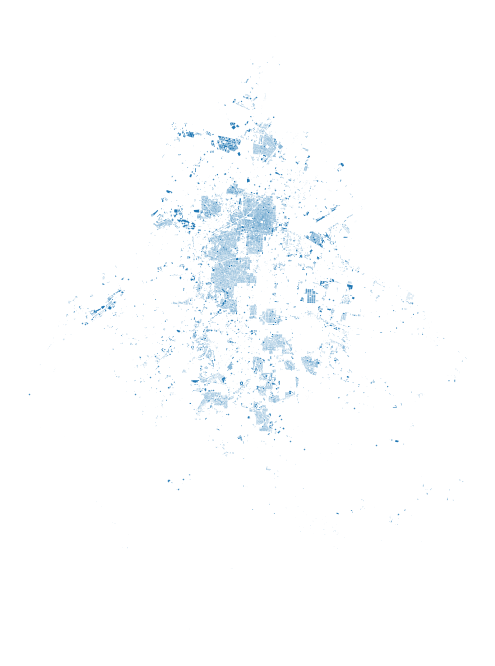

In [3]:
buildings.plot(markersize=0.2,
               figsize=(12,12))

plt.axis('off') 
plt.show()

It is evident that several buildings are not present on the map. Consequently, the resulting help centre accessibility would be partial and unreliable. In light of this, I prefer to use AGEB geographies. Note that, despite being partial, the number of buildings is high:

In [4]:
len(buildings)

116401

Thus, using these data will be computationally demanding, especially when calculating the nearest center.

## Import AGEB geographies 

In [5]:
# Read the data
gdfa = gpd.read_file('data/VAW_AGEB_clean_lag.gjson')

Like buildings, AGEBs are polygons. I have to choose a point of the geometry from which to calculate the distance.
In order to get more accurate results, I have to reproject the data to the local UTM. Use [this source](https://mangomap.com/robertyoung/maps/69585/what-utm-zone-am-i-in-#) to find out.

For Mexico City, it is [UTM14N]( https://epsg.io/6369).

In [6]:
gdfa = gdfa.to_crs(epsg=6369) #reproject to CDMX UTM

And find the centroid:

In [7]:
gdfa['centroid'] = gdfa.centroid
gdfa.head(2)

,CVEGEO,POBTOT,PRESOE15,P5_HLI,POB_AFRO,GRAPROES,PDESOCUP,PSINDER,VPH_SINLTC,VPH_SINCINT,VAW_COUNT,VAW_per_1000,VAW_per_1000_LAG,geometry,centroid
0,0900200010148,2513.0,85.0,16.0,70.0,13.26,39.0,498.0,4.0,90.0,7,2.785515,2.238242,"POLYGON ((478281.827 2156260.877, 478307.065 2...",POINT (477965.009 2155945.484)
1,0900200010190,8920.0,602.0,113.0,218.0,11.55,134.0,2011.0,76.0,600.0,34,3.811659,3.507377,"POLYGON ((480069.413 2156118.108, 480081.995 2...",POINT (479795.113 2155570.427)


Now import the Help Centre locations.

## Get Help Centre Locations from CDMX Open Data Portal


The data set is licensed under the open data licence (CC BY 4.0).

* Date source:

    [Help  Centre for Violence against Women - Mexico City Open Data Portal](https://datos.cdmx.gob.mx/dataset/servicios-de-atencion-a-violencia-contra-las-mujeres/resource/6f553628-ab08-43fe-87a3-810b41464850)



* Data Structure:

    Structure of the data is described in a separate excel file ([download here](https://datos.cdmx.gob.mx/dataset/servicios-de-atencion-a-violencia-contra-las-mujeres/resource/d7916650-b9b3-4e4a-9a69-4479a6995724))

In [8]:
# Read the data
gdf = gpd.read_file('data/servicios_de_atencion_a_violencia_contra_las_mujeres/servicios_de_atencion_a_violencia_contra_las_mujeres.shp')
gdf = gdf[gdf['_id'] != 28]
gdf.head(3)

,_id,id,id_ente,id_sede,nmbr___,calle,nmr_xtr,nmr_ntr,colonia,alcaldi,...,mdds_d_,apr____,infrm__,prfls_s,vsts_d_,a_______,at______,i______,geopont,geometry
0,1,0,FGJ,FGJ-005,Coordinacion Territorial Az-1 y Az-3,Av de las Culturas y eje 5 Norte,S/N,S/N,San Martin Xochinahuac,Azcapotzalco,...,Sí,Sí,None,None,None,None,None,None,"19.5105948,-99.1915796",POINT (-99.19158 19.51059)
1,2,1,FGJ,FGJ-007,Coordinación Territorial BJ-3 y Bj-4,Avenida Cuauhtémoc esquina Obrero Mundial,S/N,S/N,Navarte,Benito Juárez,...,Sí,Sí,None,None,None,None,None,None,"19.4018736,-99.1556199",POINT (-99.15562 19.40187)
2,3,2,FGJ,FGJ-010,Coordinación Territorial Coy-2,Zompantitla Esq. Tecualiapan,S/N,S/N,Romero de Terreros,Coyoacán,...,Sí,Sí,None,None,None,None,None,None,"19.3444204,-99.1666016",POINT (-99.16660 19.34442)


Reproject to Mexico City UTM:

In [9]:
gdf = gdf.to_crs(epsg=6369)

# Find Nearest Point 

My query is one-to-many, namely from the centrid to all possible help cetres in the city. So, I need to combine all the help centre locations in a sigle list.

In [10]:
list_points = gdf["geometry"].unary_union

And now look for the match. Given the number of points, the following operation will take some time.
Use `shapely - nearest_points` to find the closest geometry. Note that the output will refer to the liner distance.
Retrieve the name of the centre for future map displaying.

In [11]:
%%time
points = []
link_value = []

for i in range(len(gdfa)):
    nearest_geoms = nearest_points(gdfa.centroid[i], list_points)
    points.append(nearest_geoms[1])
    points_data = gdf.loc[gdf["geometry"] == points[i]]
    link_value.append(points_data['nmbr___'].values[0])
    i += 1

CPU times: user 50.5 s, sys: 2.33 ms, total: 50.5 s
Wall time: 50.5 s


Attach outputs to the AGEB geoDataFrame:

In [12]:
gdfa['closest_centre'] =  gpd.GeoSeries(points, crs="EPSG:6369") #ensure geom format
gdfa['Name_centre'] = link_value

In [13]:
gdfa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2279 entries, 0 to 2278
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   CVEGEO            2279 non-null   object  
 1   POBTOT            2279 non-null   float64 
 2   PRESOE15          2279 non-null   float64 
 3   P5_HLI            2279 non-null   float64 
 4   POB_AFRO          2279 non-null   float64 
 5   GRAPROES          2279 non-null   float64 
 6   PDESOCUP          2279 non-null   float64 
 7   PSINDER           2279 non-null   float64 
 8   VPH_SINLTC        2279 non-null   float64 
 9   VPH_SINCINT       2279 non-null   float64 
 10  VAW_COUNT         2279 non-null   int64   
 11  VAW_per_1000      2279 non-null   float64 
 12  VAW_per_1000_LAG  2279 non-null   float64 
 13  geometry          2279 non-null   geometry
 14  centroid          2279 non-null   geometry
 15  closest_centre    2279 non-null   geometry
 16  Name_centre     

At this point, compute the distance in meters using `geopands distance` and convert to km for better understanding.

In [14]:
gdfa['distance'] = gdfa.centroid.distance(gdfa.closest_centre)
gdfa['dist_km'] = gdfa['distance'] /1000

In [15]:
gdfa['dist_km'].describe()

count    2279.000000
mean        1.169192
std         0.843243
min         0.007343
25%         0.601612
50%         0.985613
75%         1.500619
max         6.715206
Name: dist_km, dtype: float64

On average, the distance from AGEB central points to the help centers is approximately 1.5 km, which is not bad, and the maximum distance from a women in danger to a safe place is less than 7 Km. Display distance on a choroplet map and compare it with the spatial lag map.  


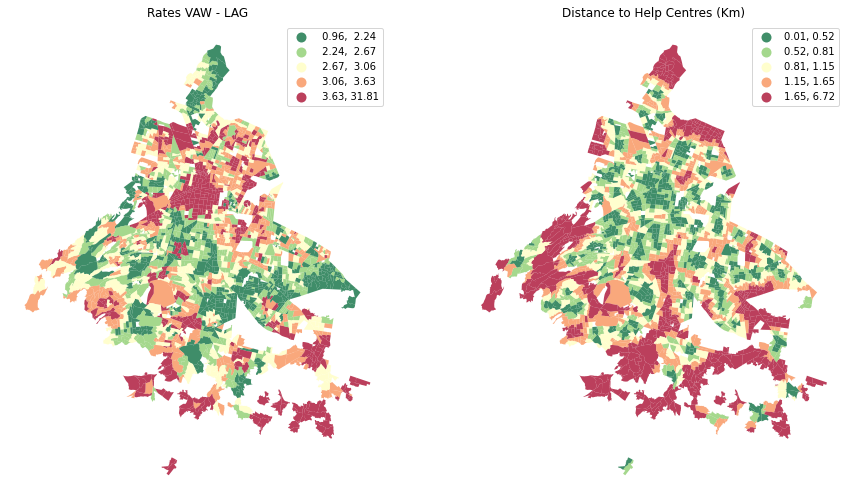

In [16]:
f, axs = plt.subplots(1, 2, figsize=(15, 12))
ax1, ax2 = axs

gdfa.plot(
    column='VAW_per_1000_LAG',
    cmap='RdYlGn_r',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("Rates VAW - LAG")


gdfa.plot(
    column='dist_km',
    cmap='RdYlGn_r',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("Distance to Help Centres (Km)")


plt.show()

As in many cities around the world, AGEBs on the outskirts of the city are those with less access to services. The distance values we have found are widely acceptable, but do they correspond to reality?

# Get street network with OSMnx


As for neighbourhoods, `OSMnx` allows to download street network data, project and plot the networks. 

It takes the name of the place, and retunrs the network within its boundary. For future calculation, I prefer to retrieve the driving network type. 

In [17]:
G = ox.graph_from_place('Mexico City, Mexico', network_type='drive')

As for the distance between AGEBs, the same story applies for the network. With `ox.project_graph`, the graph will be automatically projected to the local UTM zone.

In [18]:
G_proj = ox.project_graph(G)

Since I want to compute distance and travel time from a point A to a point B, I need to impute missing speeds and travel times:

In [19]:
G_proj = ox.speed.add_edge_speeds(G_proj)
G_proj = ox.speed.add_edge_travel_times(G_proj)

**Point A, Point B**

Choose according the greatest distance

In [20]:
gdfa.loc[gdfa["dist_km"] == max(gdfa.dist_km)]

,CVEGEO,POBTOT,PRESOE15,P5_HLI,POB_AFRO,GRAPROES,PDESOCUP,PSINDER,VPH_SINLTC,VPH_SINCINT,VAW_COUNT,VAW_per_1000,VAW_per_1000_LAG,geometry,centroid,closest_centre,Name_centre,distance,dist_km
421,0901200261710,785.0,14.0,22.0,38.0,9.95,6.0,328.0,6.0,90.0,6,7.643312,2.410339,"POLYGON ((479531.480 2125207.628, 479656.893 2...",POINT (479491.354 2124303.978),POINT (478033.049 2130858.925),Hospital General Ajusco Medio,6715.206217,6.715206


To compute distance in OSM network, I need to find the closest nodes (of the network) to my points, `gdfa.centroid` and `gdfa.closest_centre`.

In [21]:
#specify index of the selected points
i = 421

orig_node = ox.distance.nearest_nodes(G_proj, X=gdfa.centroid[i].x, Y=gdfa.centroid[i].y)
dest_node = ox.distance.nearest_nodes(G_proj, X=gdfa.closest_centre[i].x, Y=gdfa.closest_centre[i].y)

Once nodes are found, time to calculate the routes using two different parameters: length and travel time.

In [22]:
route1 = ox.shortest_path(G_proj, orig_node, dest_node, weight="length")
route2 = ox.shortest_path(G_proj, orig_node, dest_node, weight="travel_time")

Compare the routes:

In [23]:
# import datetime to convert seconds
import datetime

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_proj, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_proj, route2, "length")))

route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_proj, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_proj, route2, "travel_time")))


print("Route 1 is", route1_length/1000, "km and takes", datetime.timedelta(seconds =route1_time), "to get there by car.")
print("Route 2 is", route2_length/1000, "km and takes", datetime.timedelta(seconds =route2_time), "to get there by car.")

Route 1 is 10.645 km and takes 0:18:41 to get there by car.
Route 2 is 14.138 km and takes 0:17:45 to get there by car.


Route 2 is longer but smoother, resulting in shorter travel time.

Take a look at the distances. These values are rather out of the linear distance range, for which we had 7 km as maximum value. This tell us that linear distance is good to have a general insight on data, but not suitable for accurate analysis.

## Plotting routes on Networks

Plot the shorter route (for travel time) in green and the longer in red. 

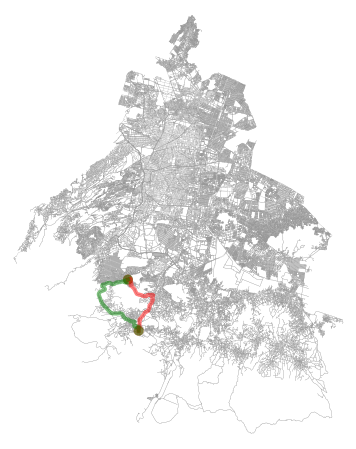

In [24]:
# plot static map
fig, ax = ox.plot_graph_routes(
    G_proj, routes=[route1, route2], route_colors=["r", "g"], route_linewidth=6, node_size=0, 
    bgcolor='w', edge_linewidth=0.2)


Great! It is easy to understad the best route. However, it is impossible to say what direction to take.
We can solve this by plotting the route in `folium`.

First, define a function that returns the shortest route for travel time.

In [25]:
def shortest_time_route(rt1,rt2,r1,r2):
    if rt1 <= rt2:
        return r1
    else:
        return r2

Store the shortest route in 'route' variable.

In [26]:
route = shortest_time_route(route1_time,route2_time,route1,route2)

The route is nothing but the sequence of OSM nodes. Let's take a look to a node:

In [27]:
G_proj.nodes[orig_node]

{'y': 2124263.8605110194,
 'x': 479429.4467834827,
 'street_count': 3,
 'lon': -99.1956934,
 'lat': 19.211704}

Inside every node, we find both the reprojected coordinates, and in the "original" CRS, namely EPSG:4326.
Use this last to build the folium map. First, create a list of the route nodes.

In [28]:
path = []

for nds in route:
    lon = G_proj.nodes[nds]['lon'] 
    lat = G_proj.nodes[nds]['lat'] 
    path.append([lat, lon])
    nds += 1

Note that latitude and longitude are inverted in non-reproject network!

In [29]:
# epsg:3426
G.nodes[orig_node]

{'y': 19.211704, 'x': -99.1956934, 'street_count': 3}

Create the map:

In [30]:
start_location=[G_proj.nodes[orig_node]['lat'], G_proj.nodes[orig_node]['lon']]
direction_m = folium.Map(location = start_location, zoom_start = 12)

#Add orig marker
folium.Marker(
  location=[G_proj.nodes[orig_node]['lat'], G_proj.nodes[orig_node]['lon']],
  tooltip='Origin',
).add_to(direction_m)

#add dest marker
folium.Marker(
  location=[G_proj.nodes[dest_node]['lat'], G_proj.nodes[dest_node]['lon']],
  popup= gdfa['Name_centre'].values[i],
  tooltip='Destination',
    icon=folium.Icon(color='red')
).add_to(direction_m)

folium.plugins.MiniMap().add_to(direction_m)

folium.plugins.AntPath(path).add_to(direction_m)


#direction_m.save("output/shortest_path.html") #save to a file
direction_m

Click on destination icon to get the name of the help centre. 

The *snake flow* tells the direction.